In [41]:
from collections import defaultdict

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#import AllTogether as t
import seaborn as sns
%matplotlib inline
df = pd.read_csv('./survey_results_public.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
df.describe()

,Respondent,CareerSatisfaction,JobSatisfaction,HoursPerWeek,StackOverflowSatisfaction,Salary,ExpectedSalary
count,19102.000000,16102.000000,15253.000000,7721.000000,13452.000000,5009.000000,818.000000
mean,9551.500000,7.343932,7.000721,3.685922,8.357865,58341.398571,32231.521687
std,5514.416757,1.919330,2.128648,7.330691,1.405546,40753.384986,28543.877274
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4776.250000,6.000000,6.000000,0.000000,8.000000,27956.989247,4716.459735
50%,9551.500000,8.000000,7.000000,1.000000,8.000000,51612.903226,29784.946237
75%,14326.750000,9.000000,8.000000,3.000000,9.000000,83333.333333,50000.000000
max,19102.000000,10.000000,10.000000,40.000000,10.000000,195000.000000,120000.000000


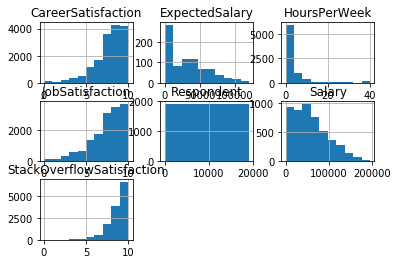

In [23]:
df.hist();

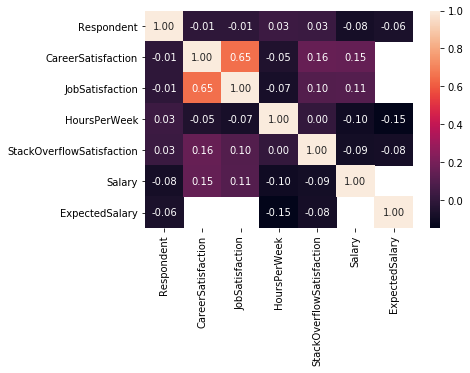

In [24]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

In [422]:
schema = pd.read_csv('./survey_results_schema.csv')

In [421]:
def get_description(column_name, schema=schema):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            desc - string - the description of the column
    '''
    desc = list(schema[schema['Column']==column_name]['Question'])[0]
    return desc
get_description(df.columns[0])

'Respondent ID number'

In [426]:
df.dtypes.value_counts()

object     147
float64      6
int64        1
dtype: int64

In [432]:
columns_type_object=[]
for index, value in df.dtypes.iteritems():
    if value == object:
        columns_type_object.append(index)
print(columns_type_object)
df_object=pd.DataFrame({'Attribute':columns_type_object, 'Description':columns_type_object})
df_object['Description'].apply(lambda x: get_description(x))

['Professional', 'ProgramHobby', 'Country', 'University', 'EmploymentStatus', 'FormalEducation', 'MajorUndergrad', 'HomeRemote', 'CompanySize', 'CompanyType', 'YearsProgram', 'YearsCodedJob', 'YearsCodedJobPast', 'DeveloperType', 'WebDeveloperType', 'MobileDeveloperType', 'NonDeveloperType', 'ExCoderReturn', 'ExCoderNotForMe', 'ExCoderBalance', 'ExCoder10Years', 'ExCoderBelonged', 'ExCoderSkills', 'ExCoderWillNotCode', 'ExCoderActive', 'PronounceGIF', 'ProblemSolving', 'BuildingThings', 'LearningNewTech', 'BoringDetails', 'JobSecurity', 'DiversityImportant', 'AnnoyingUI', 'FriendsDevelopers', 'RightWrongWay', 'UnderstandComputers', 'SeriousWork', 'InvestTimeTools', 'WorkPayCare', 'KinshipDevelopers', 'ChallengeMyself', 'CompetePeers', 'ChangeWorld', 'JobSeekingStatus', 'LastNewJob', 'AssessJobIndustry', 'AssessJobRole', 'AssessJobExp', 'AssessJobDept', 'AssessJobTech', 'AssessJobProjects', 'AssessJobCompensation', 'AssessJobOffice', 'AssessJobCommute', 'AssessJobRemote', 'AssessJobLead

0             Which of the following best describes you?
1      Do you program as a hobby or contribute to ope...
2                In which country do you currently live?
3      Are you currently enrolled in a formal, degree...
4      Which of the following best describes your cur...
5      Which of the following best describes the high...
6      Which of the following best describes your mai...
7           How often do you work from home or remotely?
8      In terms of the number of employees, how large...
9      Which of the following best describes the type...
10     How long has it been since you first learned h...
11     For how many years have you coded as part of y...
12     For how many years did you code as part of you...
13             Which of the following best describe you?
14     Which of the following best describes you as a...
15     For which of the following platforms do you de...
16                  Which of the following describe you?
17     You said before that you

In [498]:
def plots_series(df, title, yaxis, kind, rot, size_xlabel): 
    fig, ax = plt.subplots(figsize=(25,10))
    df.plot(kind=kind, rot= rot, use_index= True, grid = True, legend=None, 
            color='c', subplots= True);
    if title!=None:
        plt.title(title);
    ax.tick_params(rotation = (rot), labelsize = size_xlabel, axis='x')
    #plt.grid(b=None, which='major', axis='both')
    #ax.set_xlabel(xaxis)
    if yaxis!=None:
        ax.set_ylabel(yaxis)
    #plt.rcParams.update({'font.size': 20})
    #fig.suptitle(title)
    plt.savefig(title, bbox_inches='tight', pad_inches=0.5);

In [597]:
Gender=df.groupby(['Gender']).mean()['JobSatisfaction'].sort_values().dropna()

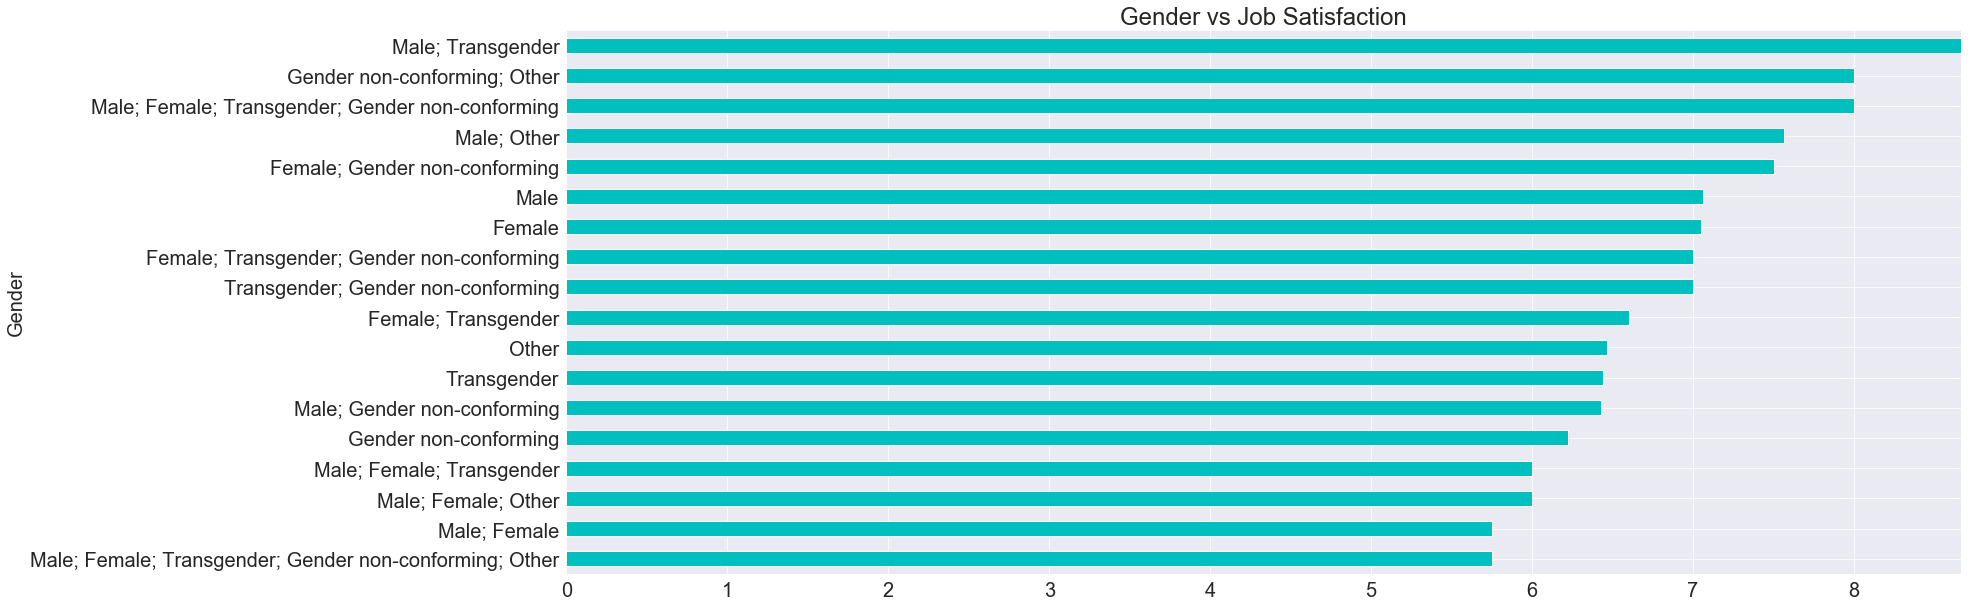

In [598]:
plots_series(Gender, 'Gender vs Job Satisfaction', None, 'barh', 0, 20)

In [573]:
dff = pd.DataFrame(df['Country'].value_counts())
dff['count'] = dff['Country']
dff['Country'] = dff['Country'].apply(lambda x: x/dff['Country'].mean())
dff.rename(columns={'Country': 'Percentage of Respondents'}, inplace=True)

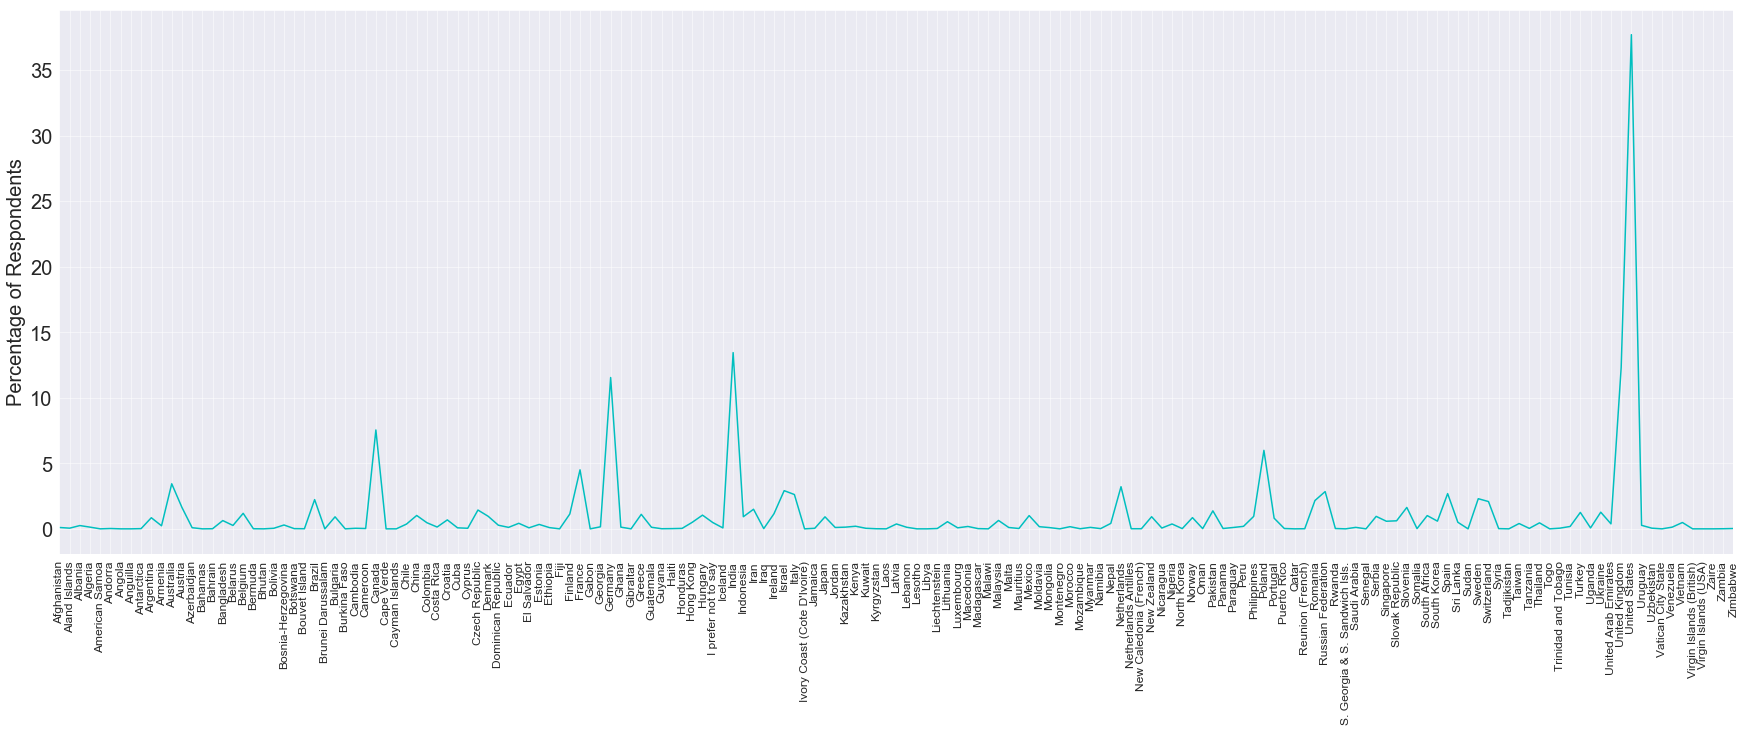

In [542]:
fig, ax = plt.subplots(figsize=(30,10))
sns.lineplot(x=dff.index, y= dff['Percentage of Respondents'], color='c')

    #plt.title(title);
ax.tick_params(rotation = (90), labelsize = 12, axis='x')
ax.tick_params(labelsize = 20, axis='y')
    #plt.grid(b=None, which='major', axis='both')
    #ax.set_xlabel(xaxis)
#ax.set_ylabel(yaxis)
#plt.rcParams.update({'font.size': 20})
    #fig.suptitle(title)
plt.rcParams['axes.xmargin'] = 0;
ax.grid(b=True, which='major', color='w', linewidth=1.0)
ax.grid(b=True, which='major', color='w', linewidth=0.5)
sns.set_style('darkgrid')
plt.savefig('Country', bbox_inches='tight', pad_inches=0.5);

In [501]:
CompanyType=df.groupby(['CompanyType']).mean()['JobSatisfaction'].sort_values().dropna()

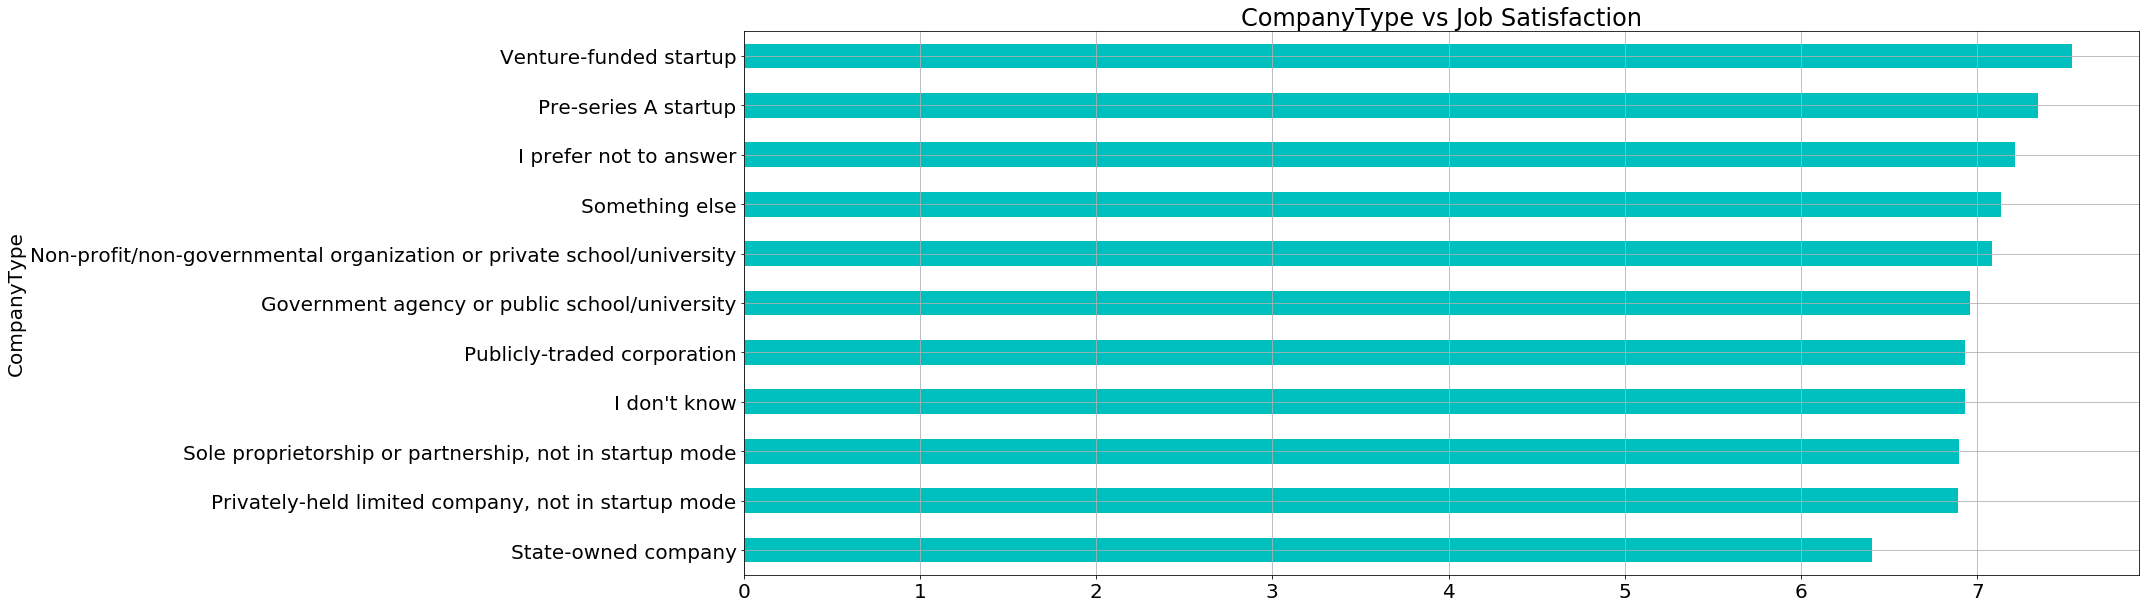

In [507]:
plots_series(CompanyType, 'CompanyType vs Job Satisfaction', None, 'barh', 0, 20)

In [492]:
HoursPerWeek=df.groupby(['HoursPerWeek']).mean()['JobSatisfaction'].dropna()

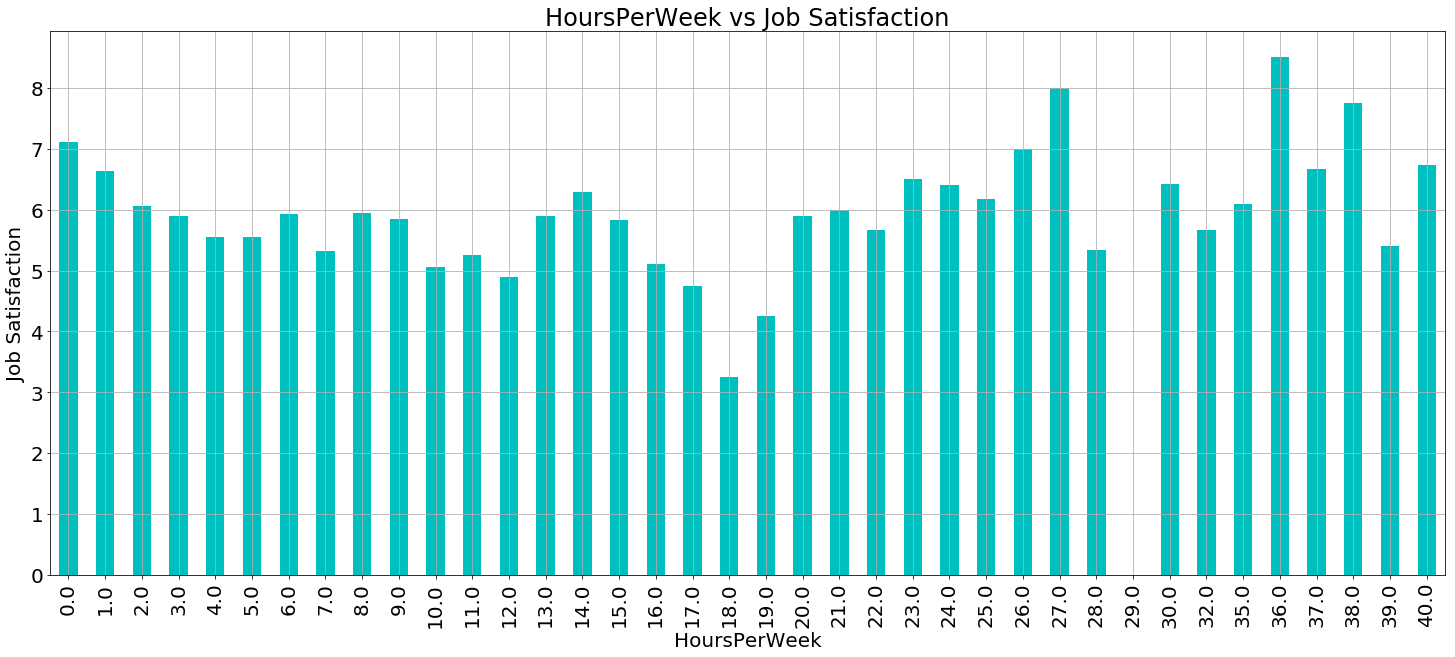

In [500]:
plots_series(HoursPerWeek, 'HoursPerWeek vs Job Satisfaction', 'Job Satisfaction', 'bar', 90, 20)

In [469]:
WorkPayCare=df.groupby(['WorkPayCare']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

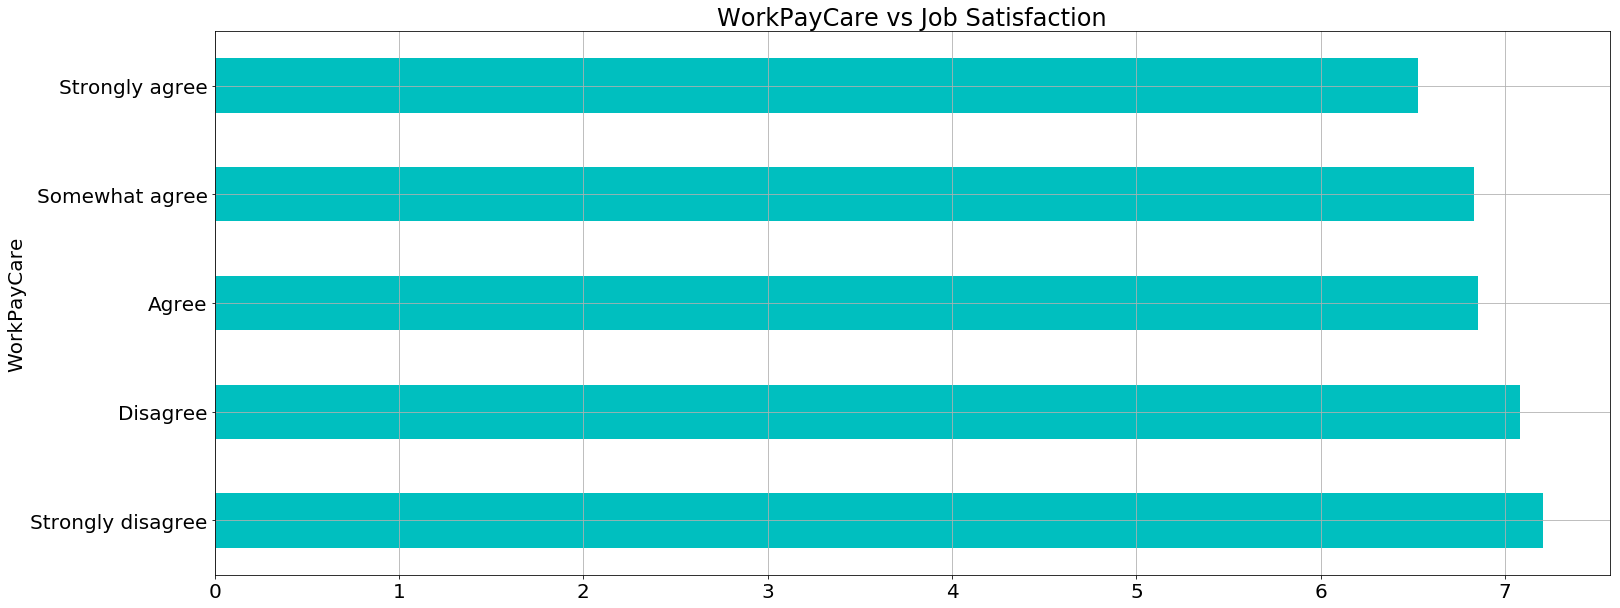

In [515]:
plots_series(WorkPayCare, 'WorkPayCare vs Job Satisfaction', 'WorkPayCare', 'barh', 0, 20)

In [465]:
HomeRemote=df.groupby(['HomeRemote']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

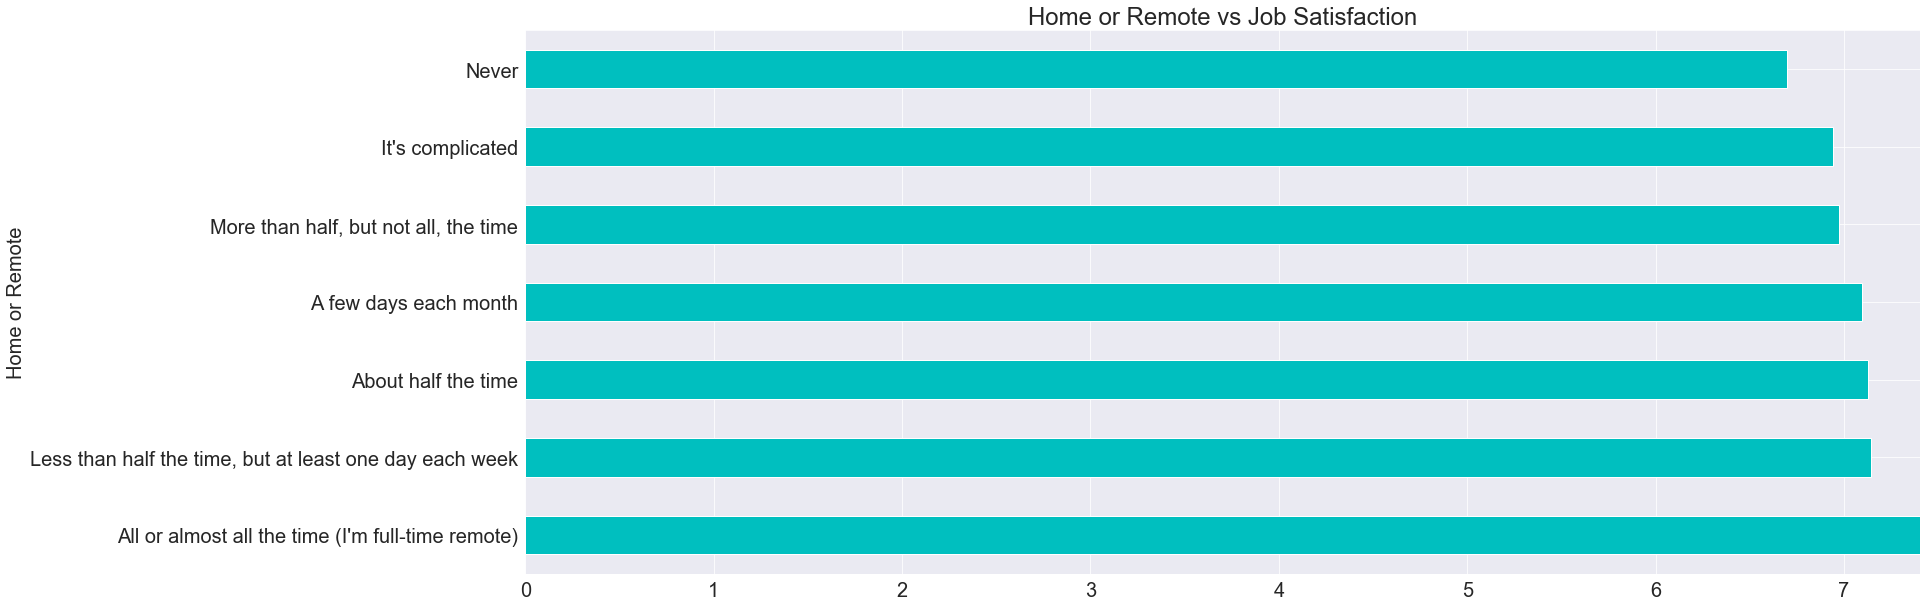

In [599]:
plots_series(HomeRemote, 'Home or Remote vs Job Satisfaction', 'Home or Remote', 'barh', 0, 20)

In [462]:
MajorUndergrad=df.groupby(['MajorUndergrad']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

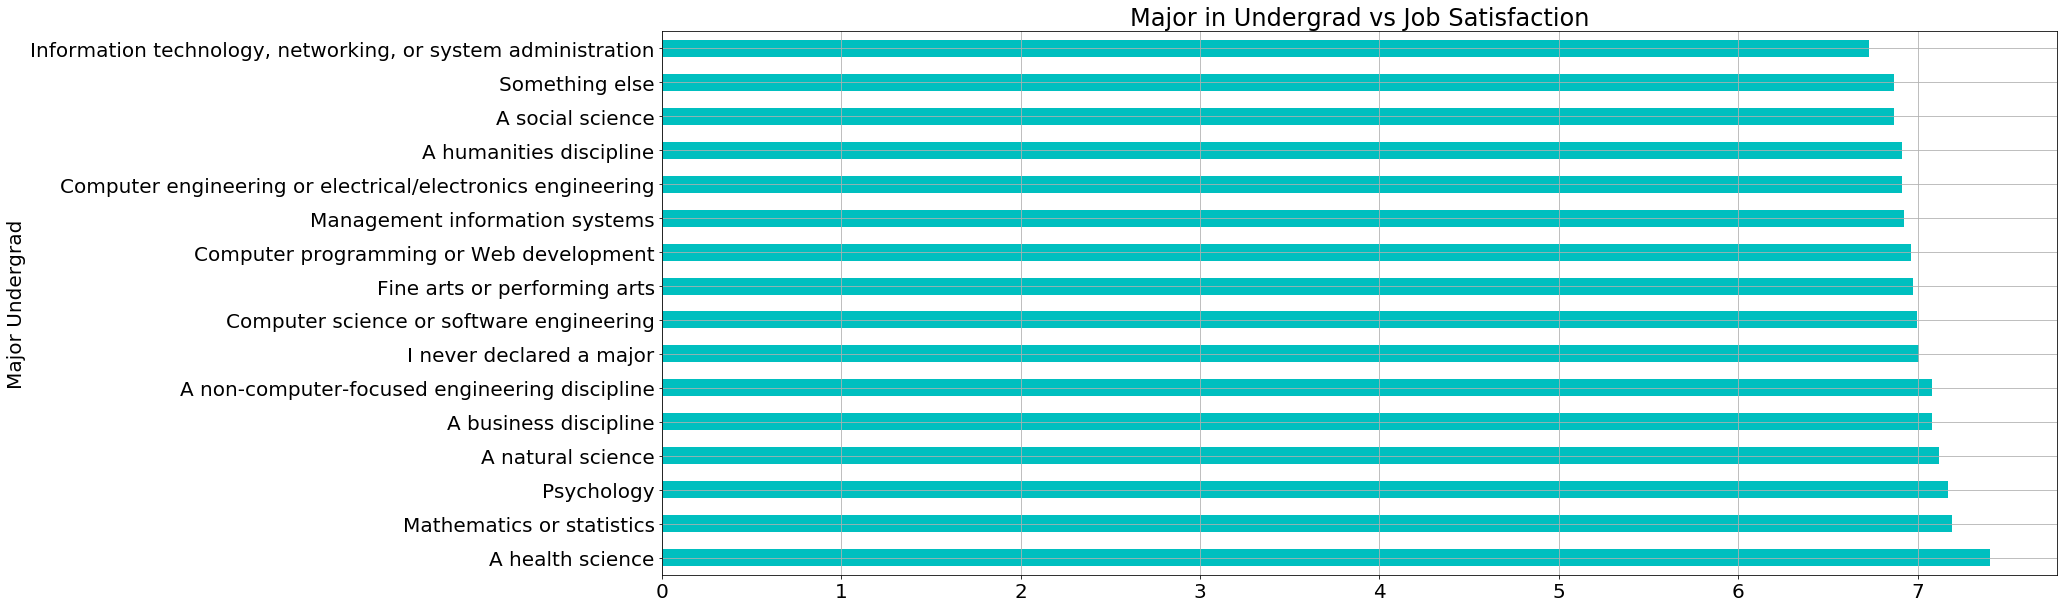

In [510]:
plots_series(MajorUndergrad, 'Major in Undergrad vs Job Satisfaction', 'Major Undergrad', 'barh', 0, 20)

In [461]:
FormalEducation=df.groupby(['FormalEducation']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

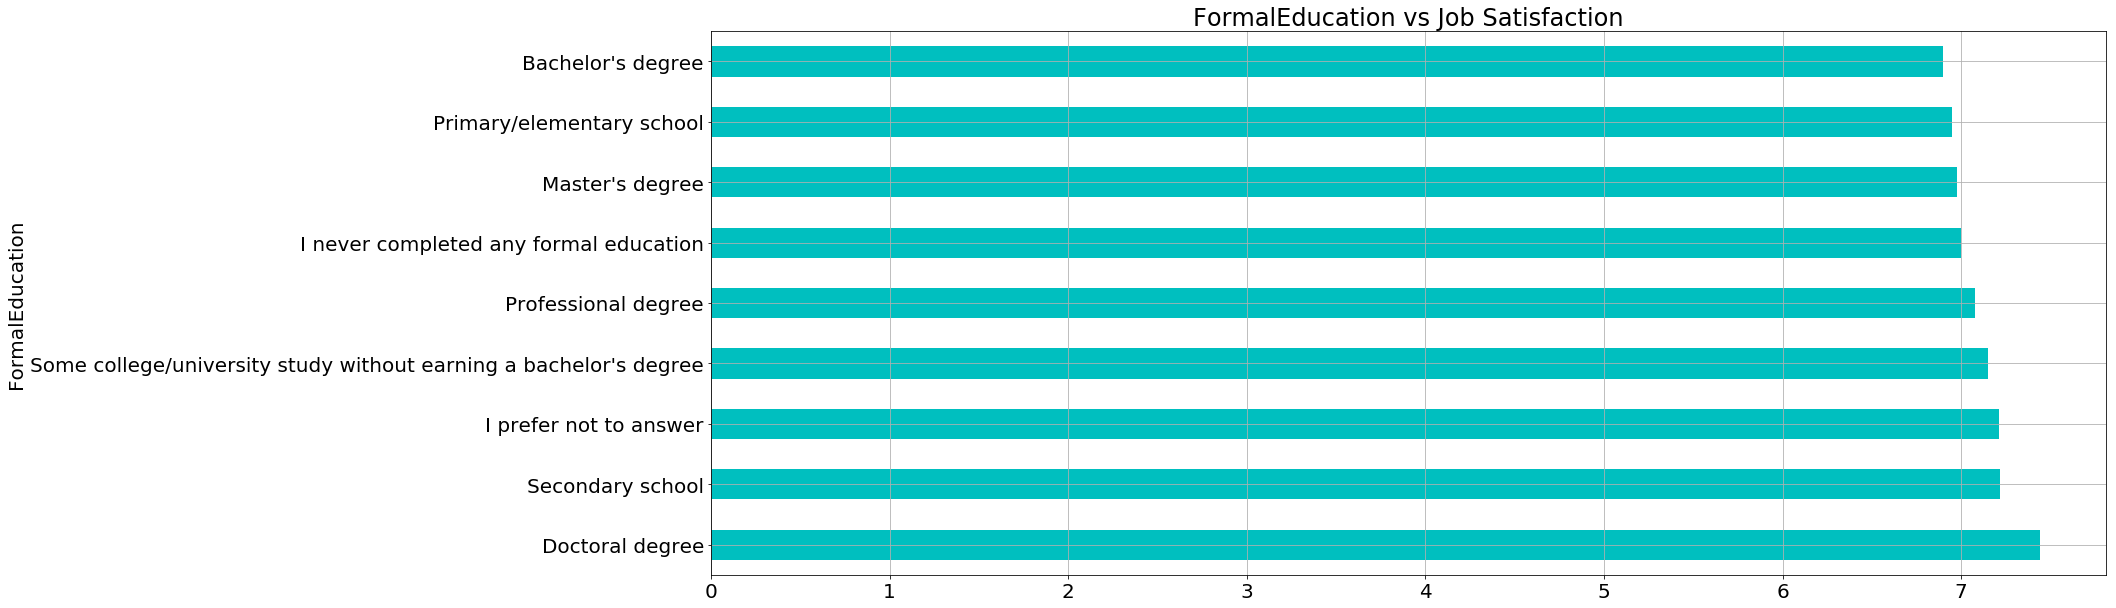

In [511]:
plots_series(FormalEducation, 'FormalEducation vs Job Satisfaction', 'FormalEducation', 'barh', 0, 20)

In [567]:
Hobby=df.groupby(['ProgramHobby']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

In [594]:
dfgre10 = dff[dff['count']>30]
listgre10=[]
listgre10=dfgre10.index
listgre10

Index(['United States', 'India', 'United Kingdom', 'Germany', 'Canada',
       'Poland', 'France', 'Australia', 'Netherlands', 'Israel',
       'Russian Federation', 'Spain', 'Italy', 'Sweden', 'Brazil', 'Romania',
       'Switzerland', 'Slovenia', 'Austria', 'Iran', 'Czech Republic',
       'Pakistan', 'Ukraine', 'Turkey', 'Belgium', 'Ireland', 'Finland',
       'Greece', 'Hungary', 'China', 'Mexico', 'South Africa', 'Denmark',
       'Philippines', 'Serbia', 'New Zealand', 'Indonesia', 'Japan',
       'Bulgaria', 'Norway', 'Argentina', 'Portugal', 'Croatia', 'Malaysia',
       'Bangladesh', 'Slovak Republic', 'South Korea', 'Singapore',
       'Lithuania', 'Hong Kong', 'Sri Lanka', 'I prefer not to say', 'Vietnam',
       'Colombia', 'Thailand', 'Egypt', 'Nepal', 'Taiwan',
       'United Arab Emirates', 'Latvia', 'Nigeria', 'Chile', 'Estonia',
       'Bosnia-Herzegovina', 'Dominican Republic', 'Uruguay', 'Belarus'],
      dtype='object')

In [595]:
location=df[df.Country.isin(listgre10)].groupby(['Country']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

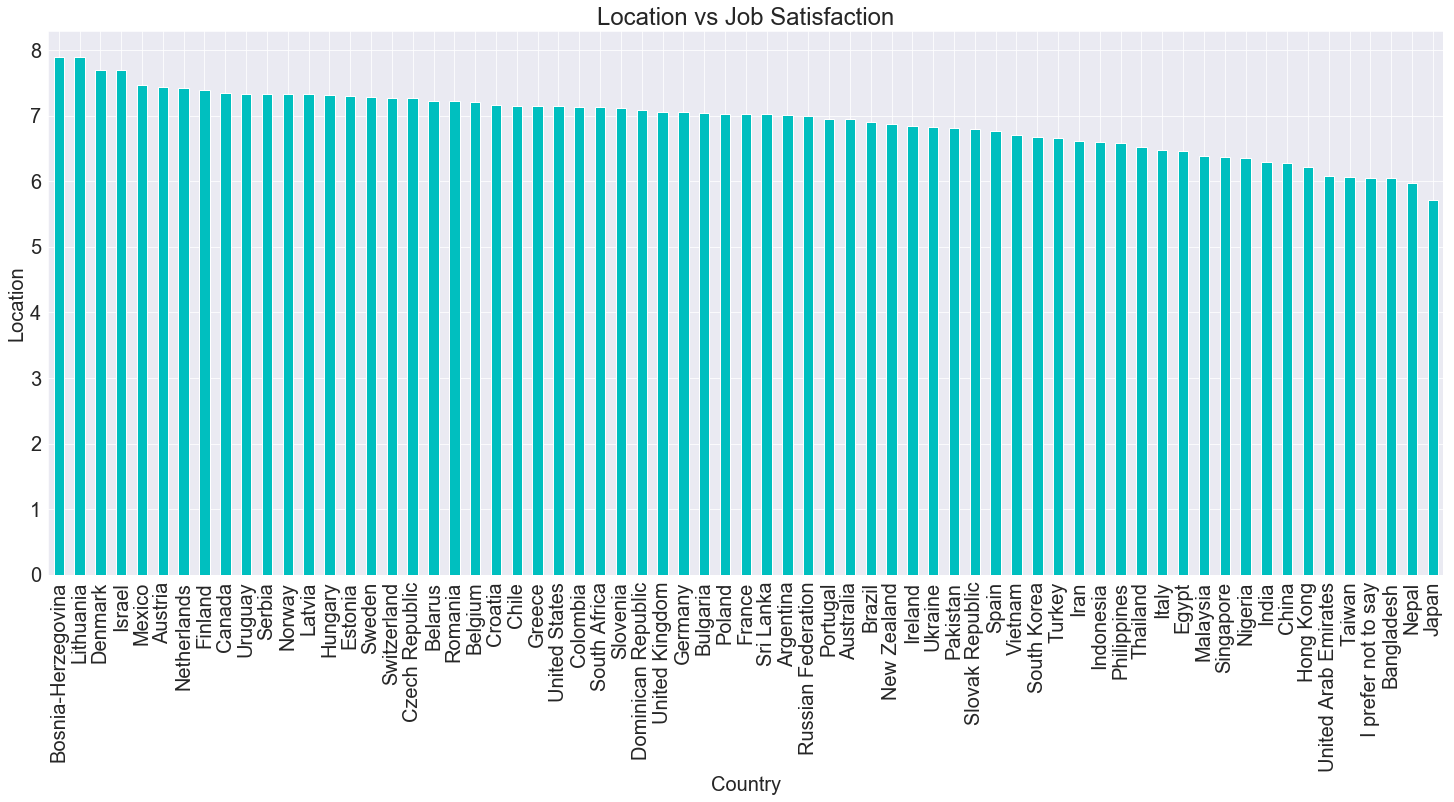

In [596]:
plots_series(location, 'Location vs Job Satisfaction', 'Location', 'bar', 90, 20)

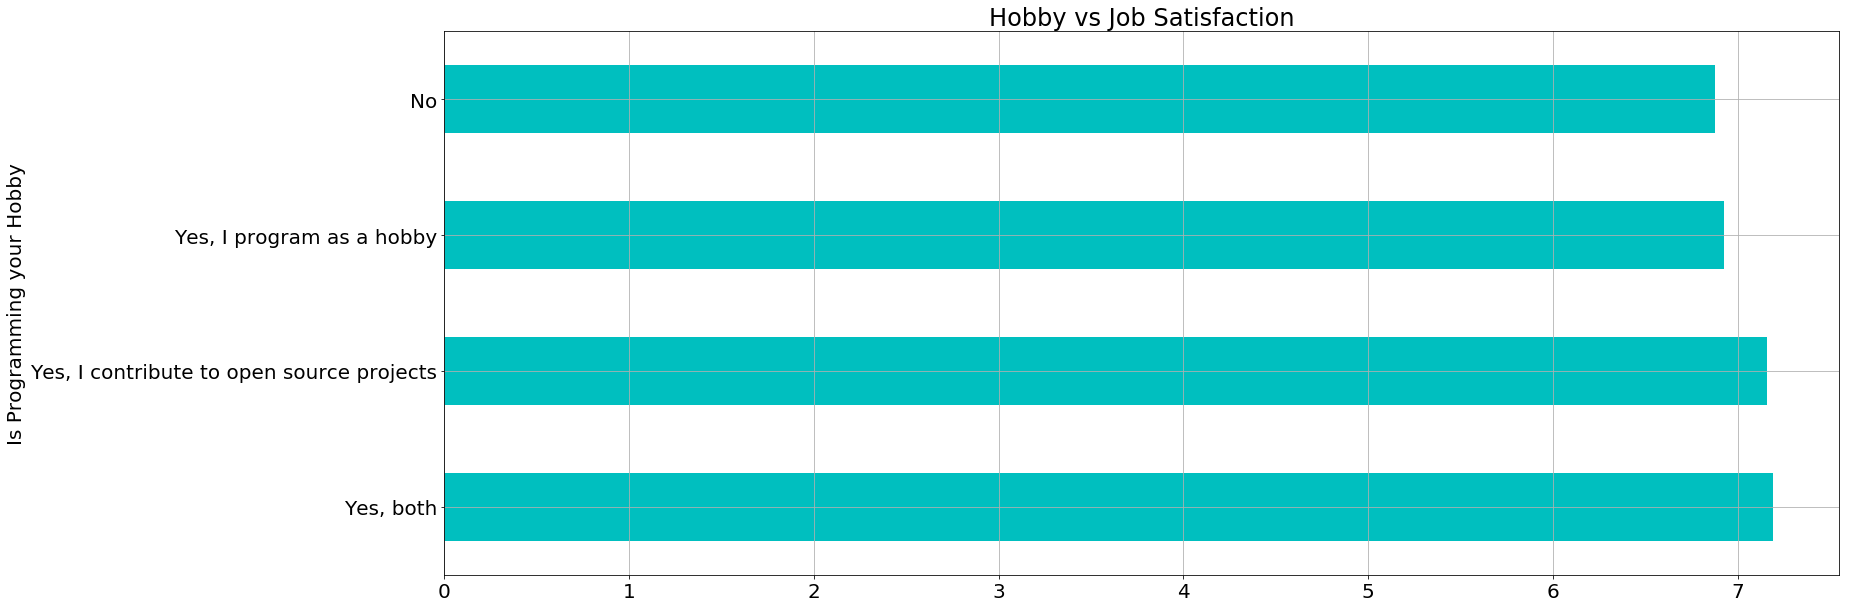

In [513]:
plots_series(Hobby, 'Hobby vs Job Satisfaction', 'Is Programming your Hobby', 'barh', 0, 20)

In [ ]:
a = 0.65
b = -0.01
c = 'ExpectedSalary'
d = 'No'
e = 'Yes'
f = 'CareerSatisfaction'
g = -0.15

scatter_sol = {'The column with the strongest correlation with Salary': f,
       'The data suggests more hours worked relates to higher salary': d,
       'Data in the ______ column meant missing data in three other columns': c,
       'The strongest negative relationship had what correlation?': g}

t.scatter_check(scatter_sol)

In [35]:
get_description('Gender')

'Which of the following do you currently identify as?'

In [36]:
get_description('CousinEducation')

"Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?\nLet's pretend you have a distant cousin named Robert. He is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. He wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Robert?\nLet's pretend you have a distant cousin named Alice. She is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. She wants your advice on how to switch to a career as a software developer. Which 

In [37]:
gender_vals = df.Gender.value_counts()#Provide a pandas series of the counts for each CousinEducation status

gender_vals # assure this looks right

Male                                                       11664
Female                                                       970
Other                                                         73
Gender non-conforming                                         54
Male; Other                                                   42
Female; Transgender                                           28
Transgender                                                   20
Male; Gender non-conforming                                   19
Female; Gender non-conforming                                 11
Transgender; Gender non-conforming                             5
Male; Female                                                   5
Male; Transgender                                              4
Male; Female; Transgender; Gender non-conforming; Other        4
Female; Transgender; Gender non-conforming                     3
Male; Female; Transgender; Gender non-conforming               2
Male; Female; Transgender

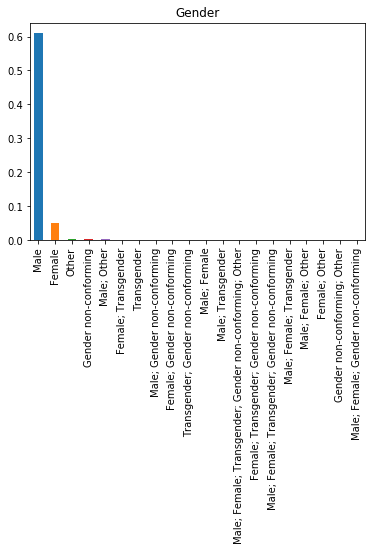

In [38]:
# The below should be a bar chart of the proportion of individuals in your ed_vals
# if it is set up correctly.

(gender_vals/df.shape[0]).plot(kind="bar");
plt.title("Gender");

In [39]:
def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of ed types
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

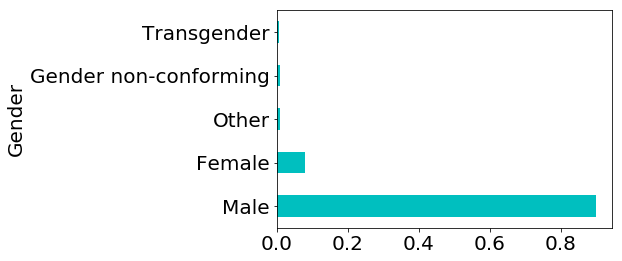

<Figure size 432x288 with 0 Axes>

In [346]:
possible_vals = ["Male", "Female", "Transgender", "Gender non-conforming", "Other"]

def clean_and_plot(df, title, plot=True):
    '''
    INPUT 
        df - a dataframe holding the CousinEducation column
        title - string the title of your plot
        axis - axis object
        plot - bool providing whether or not you want a plot back
        
    OUTPUT
        study_df - a dataframe with the count of how many individuals
        Displays a plot of pretty things related to the CousinEducation column.
    '''
    study = df[title].value_counts().reset_index()
    study.rename(columns={'index': title, title: 'count'}, inplace=True)
    study_df = total_count(study, title, 'count', possible_vals)

    study_df.set_index(title, inplace=True)
    if plot:
        (study_df/study_df.sum()).plot(kind='barh',color='c', legend=None);
        #plt.title(title);
        plt.show()
        plt.savefig(title, bbox_inches='tight', pad_inches=0.5);
    props_study_df = study_df/study_df.sum()
    return props_study_df
    
props_df = clean_and_plot(df, 'Gender')

In [25]:
df['JobSatisfaction'].isnull().mean() # missing values

0.32415453879174955

In [52]:
df.groupby(['Gender']).mean()['JobSatisfaction'].sort_values(ascending= False)

Gender
Male; Transgender                                          8.666667
Gender non-conforming; Other                               8.000000
Male; Female; Transgender; Gender non-conforming           8.000000
Male; Other                                                7.566667
Female; Gender non-conforming                              7.500000
Male                                                       7.063321
Female                                                     7.049057
Female; Transgender; Gender non-conforming                 7.000000
Transgender; Gender non-conforming                         7.000000
Female; Transgender                                        6.600000
Other                                                      6.465116
Transgender                                                6.437500
Male; Gender non-conforming                                6.428571
Gender non-conforming                                      6.222222
Male; Female; Transgender                

In [54]:
df.groupby(['Race']).mean()['JobSatisfaction'].sort_values(ascending= False)

Race
Black or of African descent; East Asian                                                                                                                                                                                          10.000000
Hispanic or Latino/Latina; Native American, Pacific Islander, or Indigenous Australian                                                                                                                                           10.000000
East Asian; Native American, Pacific Islander, or Indigenous Australian; White or of European descent                                                                                                                             9.500000
Black or of African descent; East Asian; Hispanic or Latino/Latina; Middle Eastern; Native American, Pacific Islander, or Indigenous Australian; South Asian; White or of European descent                                        9.500000
Hispanic or Latino/Latina; White or of European descent

In [56]:
df.Race.unique()

array(['White or of European descent', nan, 'Hispanic or Latino/Latina',
       'Native American, Pacific Islander, or Indigenous Australian; White or of European descent',
       'I prefer not to say', 'South Asian', 'Middle Eastern',
       'Hispanic or Latino/Latina; White or of European descent',
       'I don’t know',
       'Hispanic or Latino/Latina; Native American, Pacific Islander, or Indigenous Australian',
       'Middle Eastern; White or of European descent', 'East Asian',
       'Black or of African descent; White or of European descent',
       'Black or of African descent; East Asian; White or of European descent',
       'Middle Eastern; I don’t know',
       'East Asian; White or of European descent',
       'East Asian; South Asian; I don’t know', 'East Asian; South Asian',
       'Black or of African descent',
       'Native American, Pacific Islander, or Indigenous Australian',
       'Black or of African descent; Middle Eastern',
       'Black or of African descen

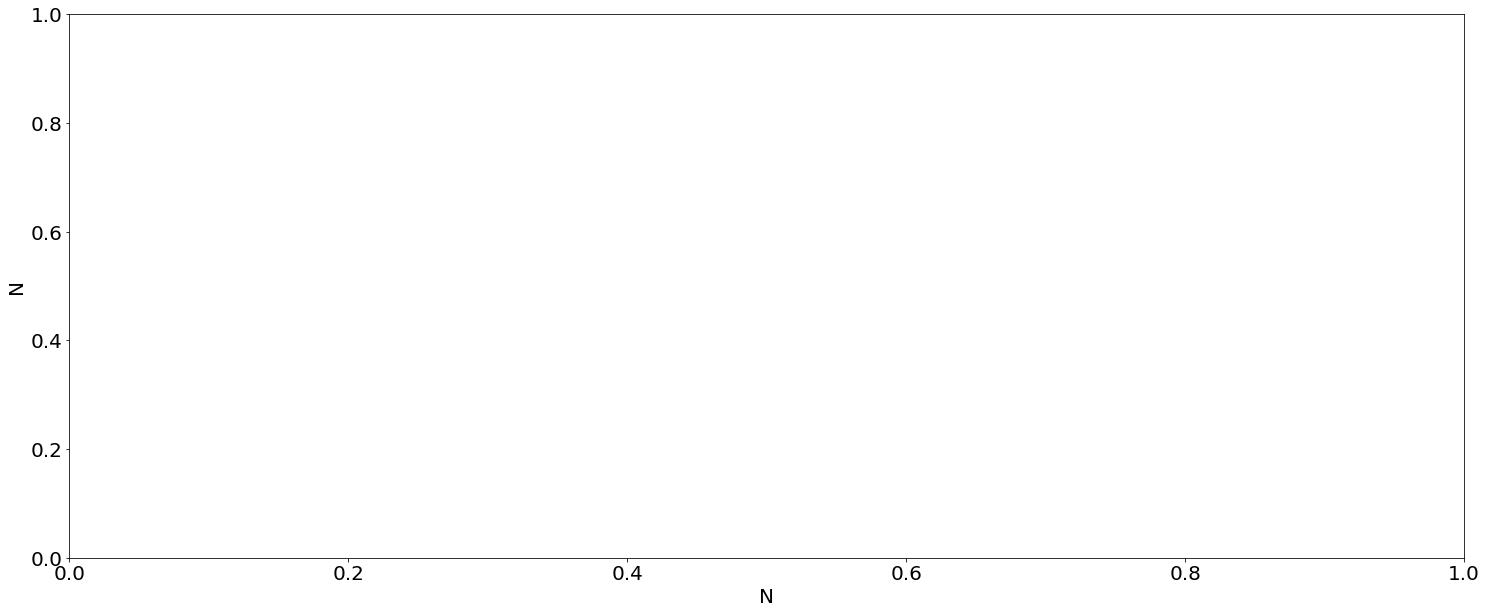

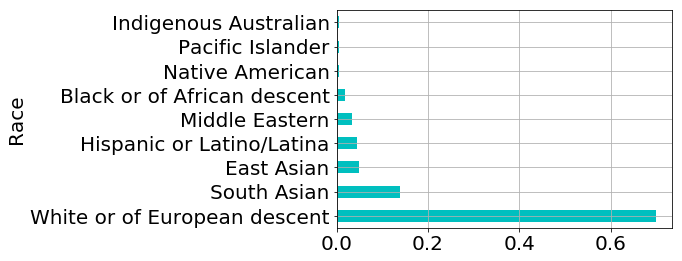

In [298]:


possible_vals = ['White or of European descent', 'Native American', 'Hispanic or Latino/Latina', 'Middle Eastern', 
'Black or of African descent', 'East Asian', 'South Asian', 'Pacific Islander', 'South Asian', 'Indigenous Australian'
]


    
props_df = clean_and_plot(df, 'Race')

In [352]:
import seaborn as sns

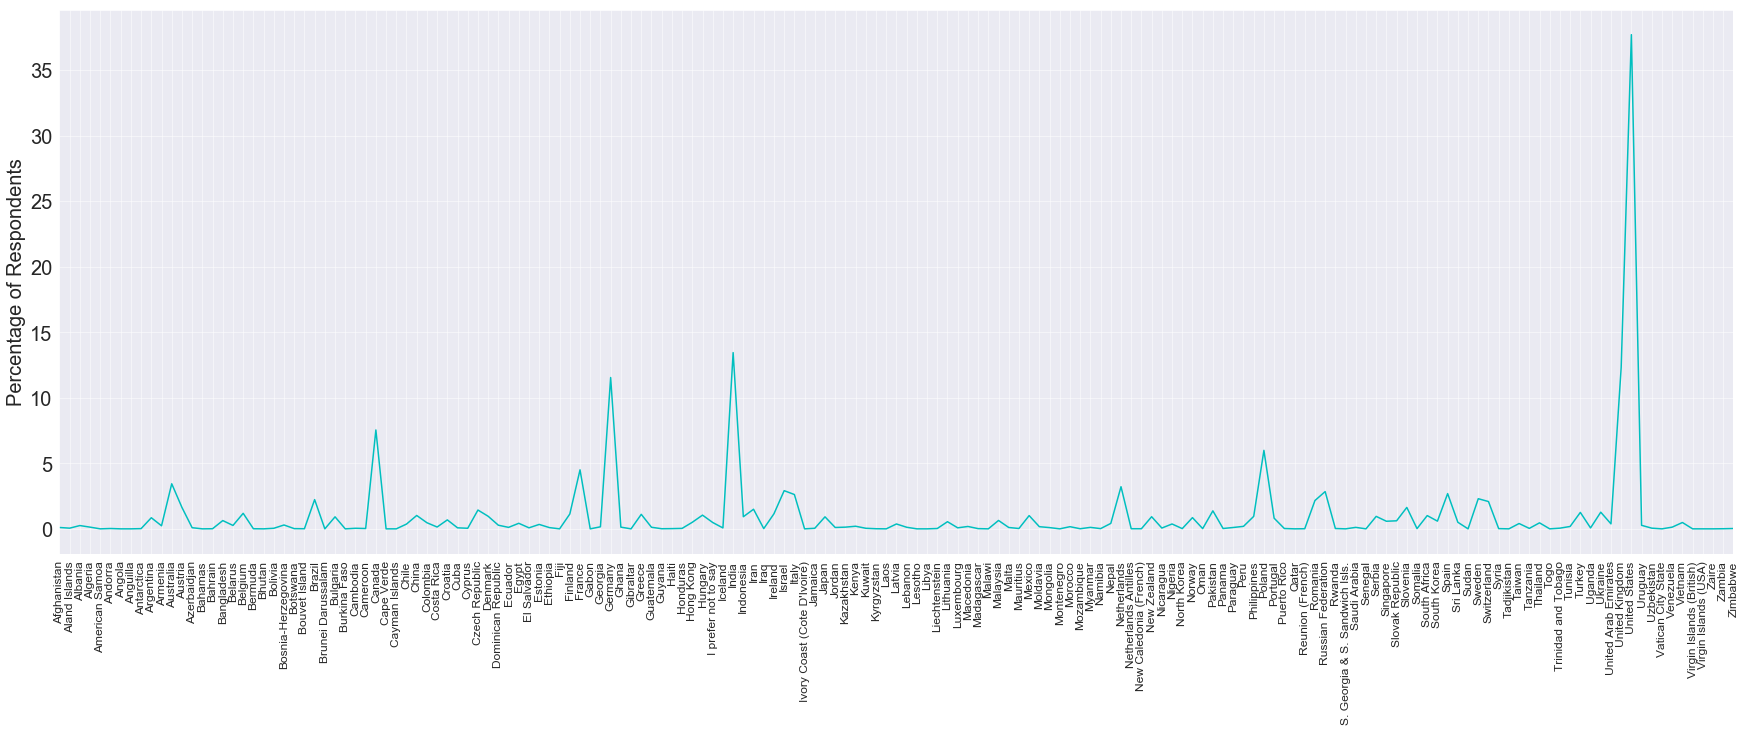

In [353]:
w=df.groupby(['Country']).mean()['Salary'].sort_values(ascending= False).dropna()
sns.scatterplot(w.index, w['Salary'], size =w['Salary'])

KeyError: 'Salary'

In [61]:
df.groupby(['Gender']).mean()['Salary'].sort_values(ascending= False).dropna()

Gender
Transgender                                                93125.000000
Female; Transgender                                        93075.725027
Male; Transgender                                          90827.272727
Female; Transgender; Gender non-conforming                 90750.000000
Male; Female; Transgender; Gender non-conforming; Other    77675.554968
Male; Gender non-conforming                                74421.786994
Gender non-conforming                                      67399.987781
Female; Gender non-conforming                              65103.787879
Male; Other                                                63491.419071
Transgender; Gender non-conforming                         59086.021505
Male                                                       59080.990450
Female                                                     57000.666971
Male; Female                                               55385.300974
Other                                                    

In [62]:
df.groupby(['Gender']).mean()['Salary'].sort_values().dropna()

Gender
Male; Female; Transgender                                  12000.000000
Male; Female; Other                                        15000.000000
Other                                                      49456.283362
Male; Female                                               55385.300974
Female                                                     57000.666971
Male                                                       59080.990450
Transgender; Gender non-conforming                         59086.021505
Male; Other                                                63491.419071
Female; Gender non-conforming                              65103.787879
Gender non-conforming                                      67399.987781
Male; Gender non-conforming                                74421.786994
Male; Female; Transgender; Gender non-conforming; Other    77675.554968
Female; Transgender; Gender non-conforming                 90750.000000
Male; Transgender                                        

In [30]:
### from the exercise

In [64]:
df.groupby(['EmploymentStatus']).mean()['JobSatisfaction'].sort_values(ascending= False).dropna()

EmploymentStatus
Independent contractor, freelancer, or self-employed    7.231985
Employed full-time                                      6.980608
Employed part-time                                      6.846154
Name: JobSatisfaction, dtype: float64

In [66]:
df.groupby(['CompanySize']).mean()['JobSatisfaction'].sort_values(ascending= False).dropna()

CompanySize
I prefer not to answer      7.284946
I don't know                7.054622
10 to 19 employees          7.035739
500 to 999 employees        7.029967
100 to 499 employees        7.029324
Fewer than 10 employees     7.025719
20 to 99 employees          6.997039
1,000 to 4,999 employees    6.908506
5,000 to 9,999 employees    6.832155
10,000 or more employees    6.793617
Name: JobSatisfaction, dtype: float64

C:\Users\rdixit\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_core.py:211: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn("'color' and 'colormap' cannot be used "
C:\Users\rdixit\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_style.py:31: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  warnings.warn("'color' and 'colormap' cannot be used "
C:\Users\rdixit\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\base.py:2084: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)
C:\Users\rdixit\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\base.py:2084: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)
C:\Users\rdixit\AppData\Local\Continuum\anaconda3\li

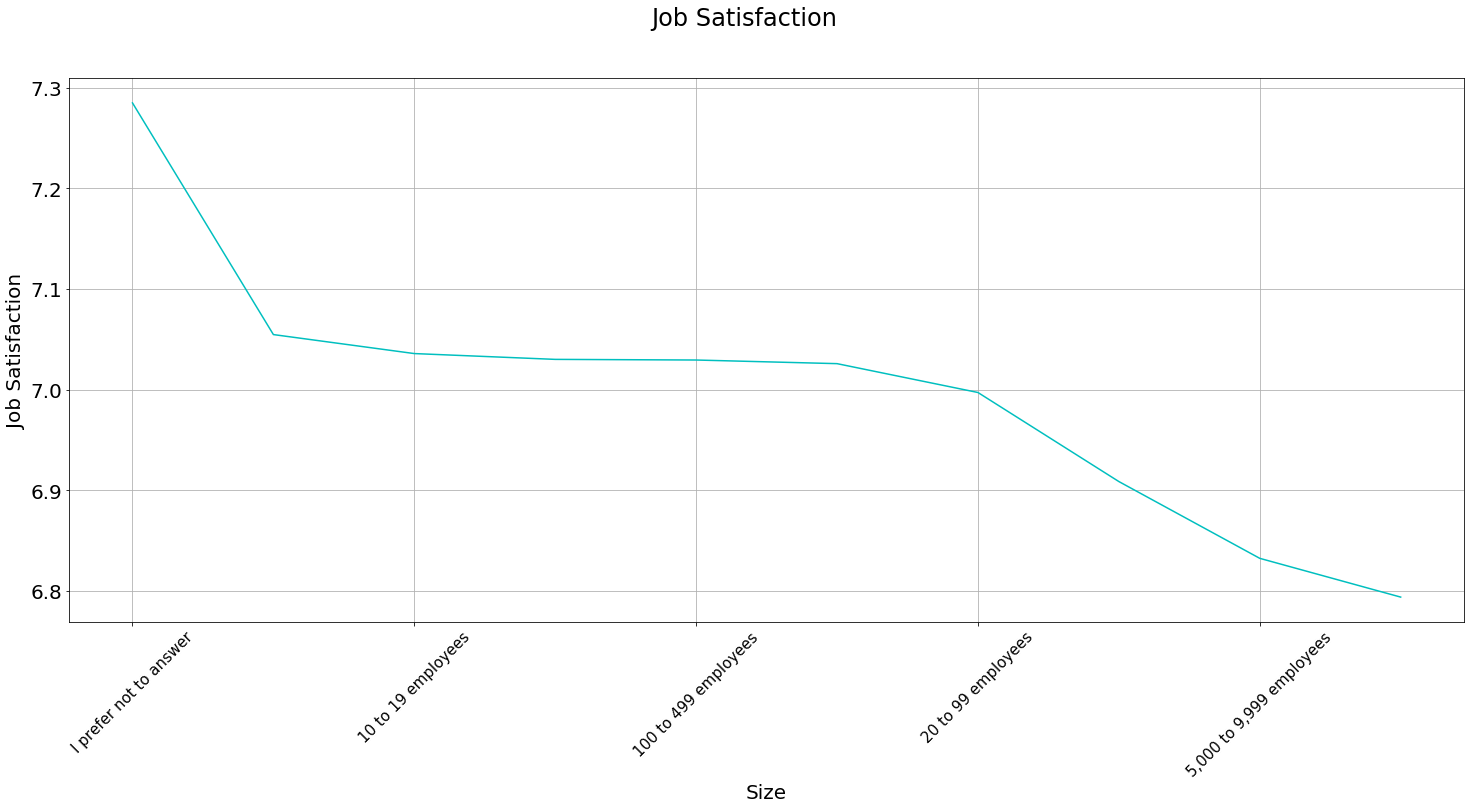

In [139]:
a = df.groupby(['CompanySize']).mean()['JobSatisfaction'].sort_values(ascending= False).dropna()
plots(a, 'Job Satisfaction', 'Size', 'Job Satisfaction', 'line')

In [109]:
df.groupby(['ProgramHobby']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()

ProgramHobby
Yes, both                                    7.189316
Yes, I contribute to open source projects    7.158649
Yes, I program as a hobby                    6.927150
No                                           6.874806
Name: JobSatisfaction, dtype: float64

C:\Users\rdixit\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\base.py:2084: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)
C:\Users\rdixit\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\base.py:2084: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)
C:\Users\rdixit\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\base.py:2084: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)
C:\Users\rdixit\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexes\base.py:2084: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)
C:\Users\rdixit\AppData\Local\Continuum\anaconda

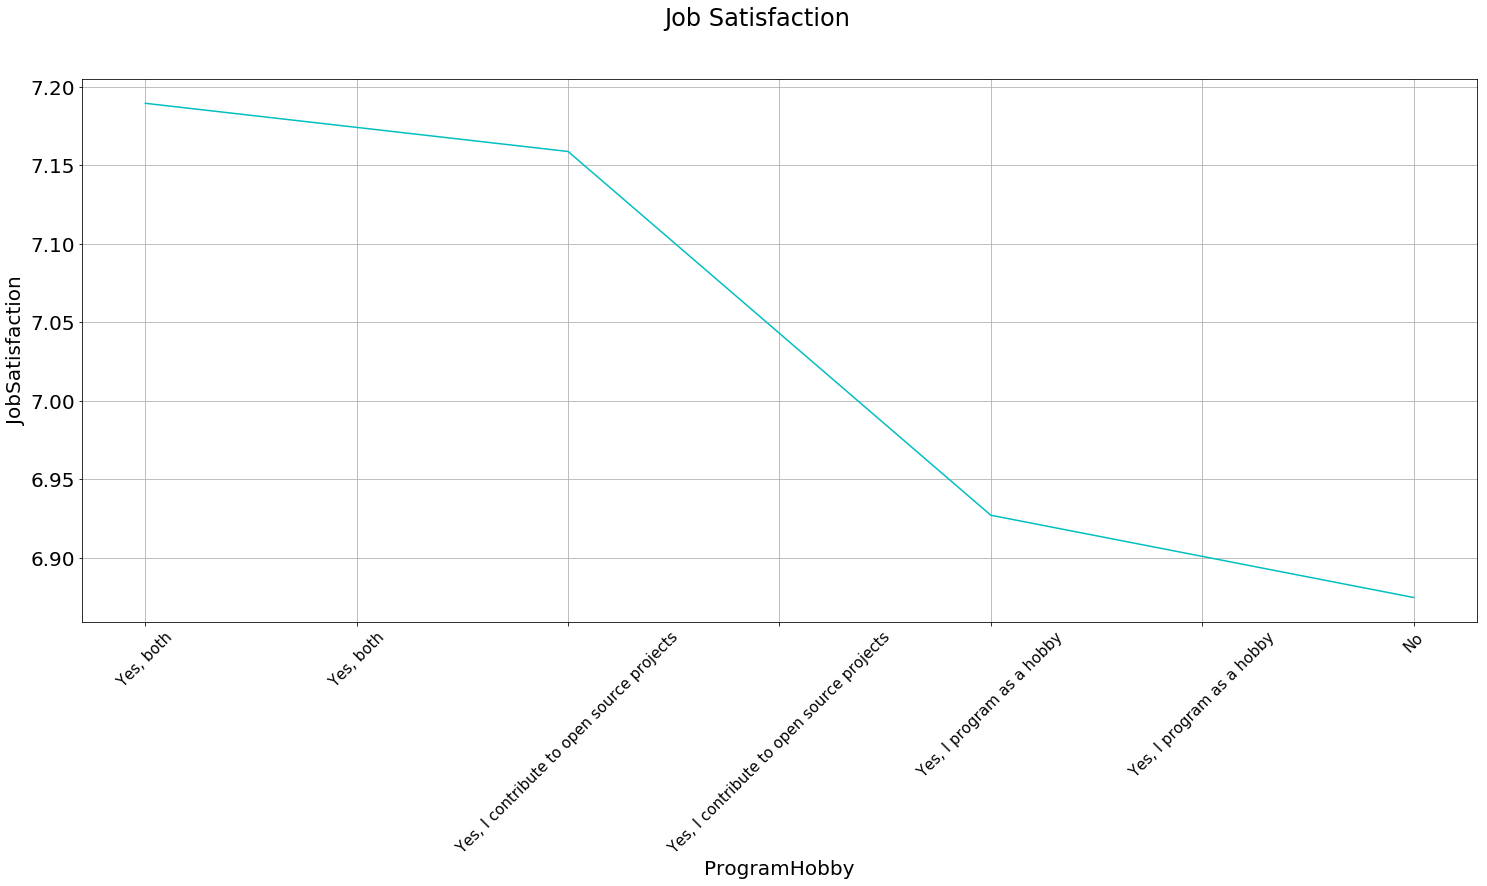

In [112]:
b=df.groupby(['ProgramHobby']).mean()['JobSatisfaction'].sort_values(ascending = False).dropna()
plots(b, 'Job Satisfaction', 'ProgramHobby', 'JobSatisfaction', 'line')

In [33]:
df.groupby(['HomeRemote']).mean()['JobSatisfaction'].sort_values().dropna()

HomeRemote
Never                                                      6.697127
It's complicated                                           6.942053
More than half, but not all, the time                      6.973684
A few days each month                                      7.096694
About half the time                                        7.125737
Less than half the time, but at least one day each week    7.143786
All or almost all the time (I'm full-time remote)          7.405421
Name: JobSatisfaction, dtype: float64

In [34]:
res = df.groupby(['FormalEducation']).mean()['JobSatisfaction'].sort_values().dropna()
res

FormalEducation
Bachelor's degree                                                    6.900293
Primary/elementary school                                            6.946237
Master's degree                                                      6.977356
I never completed any formal education                               7.000000
Professional degree                                                  7.075893
Some college/university study without earning a bachelor's degree    7.151268
I prefer not to answer                                               7.211679
Secondary school                                                     7.219512
Doctoral degree                                                      7.438492
Name: JobSatisfaction, dtype: float64

In [3]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no salaries
    2. Create X as all the columns that are not the Salary column
    3. Create y as the Salary column
    4. Drop the Salary, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing salary values
    df = df.dropna(subset=['Salary'], axis=0)
    y = df['Salary']
    
    #Drop respondent and expected salary columns
    df = df.drop(['Respondent', 'ExpectedSalary', 'Salary'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df)    

In [4]:
X.shape, y.shape

((5009, 11935), (5009,))

In [5]:
def get_description(column_name, schema=schema):
    '''
    INPUT - schema - pandas dataframe with the schema of the developers survey
            column_name - string - the name of the column you would like to know about
    OUTPUT - 
            desc - string - the description of the column
    '''
    desc = list(schema[schema['Column']==column_name]['Question'])[0]
    return desc
get_description(df.columns[0])

'Respondent ID number'

In [21]:
len(X.columns)

11935

In [16]:
df['Race'].nunique()

59